In [1]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore",category=mpl.cbook.mplDeprecation)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.hot)
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (10, 3),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
import random
from datetime import datetime
from time import time
from numpy import random as nprand
random.seed(datetime.now())
nprand.seed(int(time()))
# Import NetworkX
import networkx as nx
# Import copy
from copy import deepcopy
# Import Numpy
import numpy as np
# Import Pandas
import pandas as pd
# Import SciKit Learn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
NUM_FIRMS = 50
WORKERS_PER_FIRM = 15
TIME_STEPS = 15

In [3]:
class Worker:
    def __init__(self, id, initial_sentiment):
        self.id = id
        self.sentiments = {0: initial_sentiment}
        self.contacted = False
        
    def contact(self, time, organizer_skill=1):
        """Updates sentiment for worker based on current sentiment and organizer skill."""
        time = sorted(self.sentiments.keys())[-1]
        self.sentiments[time] = min(organizer_skill, 1)
        self.contacted = True

In [4]:
class Organizer:
    def __init__(self, skill):
        self.skill = skill
    
    def contact_firm(self, firm, time, n_contacted=1):
        """Contact random workers in the firm"""
        for i in range(n_contacted): 
            worker = random.choice(firm.workers)
            while worker.contacted:
                worker = random.choice(firm.workers)
            worker.contact(time, self.skill)

In [5]:
class Firm:
    def __init__(self, name, n=WORKERS_PER_FIRM, sentiment_mean=0.3, sentiment_std=0.1, m=10, p=0.5):
        m = m if m else max(0, min(random.gauss(10, 2), 20))
        p = p if p else max(0, min(random.gauss(p, 0.2), 1))
        self.G = nx.powerlaw_cluster_graph(n, m, p)
        self.name = name
        self.size = n
        self.sentiments = None
        self.sentiment_mean = sentiment_mean
        self.sentiment_std = sentiment_std
        self.workers = []
        for index, initial_sentiment in enumerate(self.init_sentiments()):
            self.workers.append(Worker(index, initial_sentiment))
        
    def init_sentiments(self):
        """Generate estimates of a true value with normally-distributed errors."""
        beliefs = [max(0, random.gauss(self.sentiment_mean, self.sentiment_std)) for x in range(self.size)]
        return beliefs 
    
    def copy(self):
        return deepcopy(self)
    
    def get_neighbors(self, worker):
        return [w for w in self.workers if w.id in self.G.neighbors(worker.id)]
    
    def learning_step(self, time):
        """Update each node's beliefs based on its neighbors' beliefs"""
        for w in self.workers:
            # Include old belief in average
            total = w.sentiments[time]
            count = 1
            # Update average based on each neighbor
            for n in self.get_neighbors(w):
                total += n.sentiments[time]
                count += 1
            # Calculate average for node w
            w.sentiments[time + 1] = total / count
    
    def get_stats(self):
        initial_sentiments = [w.sentiments[0] for w in self.workers]
        initial_mean = np.mean(initial_sentiments)
        initial_var = np.var(initial_sentiments)
        mean_degree = np.sum([self.G.degree[node] for node in self.G.nodes()]) / float(self.size)
        adj_mat = nx.linalg.spectrum.adjacency_spectrum(self.G)
        lapl_mat = nx.linalg.spectrum.laplacian_spectrum(self.G)
        stats = {'initial_mean': initial_mean,
                 'initial_var': initial_var,
                 'mean_degree': [mean_degree],
                 'adj_mat': sorted(adj_mat, reverse=True)[:2],
                 'lapl_mat': sorted(lapl_mat, reverse=True)[:2]}
        return stats
    
    def display(self):
        colors_contacted = {w.id: cmap.to_rgba(w.sentiments[0]) for w in self.workers}
        print(pd.DataFrame.from_dict(self.get_stats(), orient='index').to_string())
        nx.draw(self.G, node_color=list(colors_contacted.values()), edgecolors=[0,0,0])
    
    def learn_sentiments(self, steps=10):
        """Learn sentiments over time."""
        # Repeatedly update beliefs
        start_time = len(self.workers[0].sentiments)
        for i in range(steps):
            self.learning_step(i)
            
    def get_sentiments(self):
        x = {w.id: sorted(w.sentiments.keys()) for w in self.workers}
        y = {w.id: [w.sentiments[time] for time in [x[w.id][i] for i in x[w.id]]] for w in self.workers}
        return [x, y]
    
    def get_mean_sentiment(self, time):
        current_sentiments = [w.sentiments[time] for w in self.workers]
        return np.mean(current_sentiments)
    
    def plot_sentiments(self):
        x, y = self.get_sentiments()
        steps = len(x[self.workers[0].id])
        initial_sentiments = [w.sentiments[0] for w in self.workers]
        # Plot evolution of each node's beliefs
        for i, w in enumerate(self.workers):
            plt.plot(x[w.id], y[w.id], 'b-', alpha=0.3, linewidth=2, label='Indvidual worker' if i ==0 else None)
        # Plot mean value
        mean_value = sum(initial_sentiments) / len(initial_sentiments)
        plt.plot([0, steps], [mean_value, mean_value], 'k:', label='Initial mean')
        plt.legend()
        # Add spines to plot
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(True)
        plt.xlim([0, steps])
        plt.ylim([0, 1])

### Seed 50 control firms and 50 treatment firms

In [6]:
F_control_set = [Firm('Control {}'.format(i)) for i in range(NUM_FIRMS)]
F_contacted_set = [F_control.copy() for F_control in F_control_set]

for F_control in F_control_set:
    #learn control
    F_control.learn_sentiments(TIME_STEPS)
    
organizer = Organizer(1) 
for F_contacted in F_contacted_set:
    # contact contacted
    organizer.contact_firm(F_contacted, 0, 5)
    # learn contacted
    F_contacted.learn_sentiments(TIME_STEPS)

#### Example control firm:

                                                              0
initial_mean                                           0.282117
initial_var                                           0.0075412
mean_degree                                 [6.666666666666667]
adj_mat       [(8.182360605753026+0j), (1.3998807191334932+0j)]
lapl_mat               [14.999999999999996, 14.037146349433284]


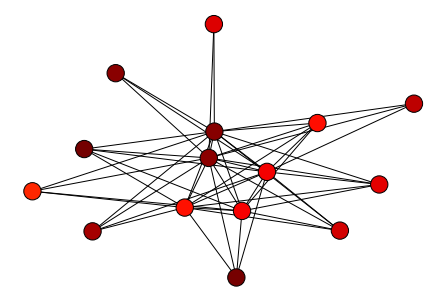

In [7]:
F_control_ex = F_control_set[0]
F_control_ex.display()

#### Example treatment firm:

                                                              0
initial_mean                                           0.532345
initial_var                                            0.113184
mean_degree                                 [6.666666666666667]
adj_mat       [(8.182360605753026+0j), (1.3998807191334932+0j)]
lapl_mat               [14.999999999999996, 14.037146349433284]


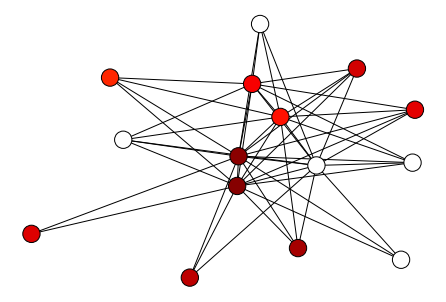

In [8]:
F_contacted_ex = F_contacted_set[0]
F_contacted_ex.display()

### Plot sentiments for example firms in control and treatment pools

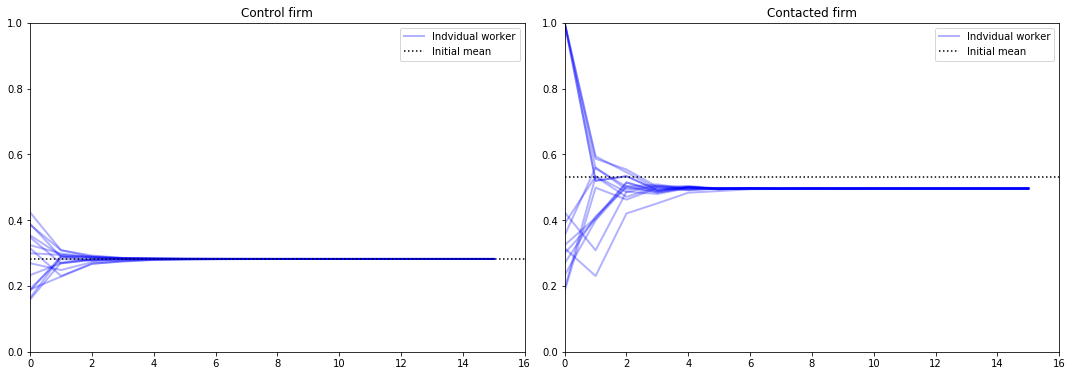

In [9]:
firms = {
    'Control firm': F_control_ex,
    'Contacted firm': F_contacted_ex }

# Plot sentiments for sample firms
plt.rcParams.update({'figure.figsize': (15, 15)})
for i, (title, F) in enumerate(firms.items()):
    plt.subplot(3, 2, i + 1)
    plt.title(title)
    F.plot_sentiments()
plt.tight_layout()

### Plot mean sentiments for all firms in control and treatment pools

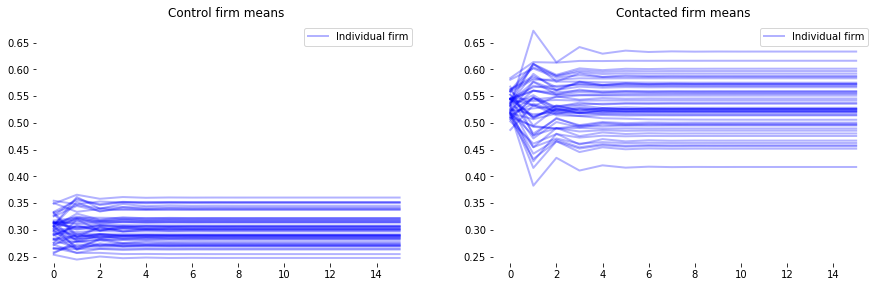

In [10]:
def plot_firm_means(firms):
    """Plot mean sentiments over time for sample firms"""
    plt.rcParams.update({'figure.figsize': (15, 15)})
    for i, F in enumerate(firms):
        x, y = F.get_sentiments()
        means = []
        for j in range(len(y[0])):
            current_sentiments = [y[w.id][j] for w in F.workers]
            means.append(np.mean(current_sentiments))
        plt.plot(range(len(y[0])), means, 'b-', alpha=0.3, linewidth=2, label='Individual firm' if i ==0 else None)
    plt.legend()

# Plot control firms
subplt_control = plt.subplot(3, 2, 1)
plt.title('Control firm means')
plot_firm_means(F_control_set)
min_control, max_control = plt.ylim()

# Plot contacted firms
subplt_contacted = plt.subplot(3, 2, 2)
plt.title('Contacted firm means')
plot_firm_means(F_contacted_set)
min_contacted, max_contacted = plt.ylim()

# Scale axes on compatible sentiment range
for subplt in [subplt_control, subplt_contacted]:
    plt.setp(subplt, ylim=(min(min_control, min_contacted), max(max_control, max_contacted)))

### Regression table

Eventually, this should be performed on a timestep, such that degree, eigenvalue, etc. are calculated at each step.

In [41]:
VAL_PERCENT = 0.2

def split_train_val(data, val_percent=0.2):
    random.shuffle(data)
    train = np.array(data[:int(-val_percent * len(data))]).reshape(-1, 1)
    val = np.array(data[int(-val_percent * len(data)):]).reshape(-1, 1)
    return [train, val]

def regress(x_data, y_data):
    y_train, y_val = split_train_val(y_data, VAL_PERCENT)
    x_train, x_val = split_train_val(x_data, VAL_PERCENT)
    # Train model using the training sets
    plt.scatter(x_val, y_val, color='red', label='Regression val')
    plt.scatter(x_train, y_train, label='Regression train')
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    # Make predictions using the testing set
    predictor = regr.predict(x_val)
    m = round(regr.coef_[0][0], 2)
    b = round(regr.intercept_[0], 2)
    r2 = round(r2_score(y_val, predictor), 2)
    plt.plot(x_val, predictor, color='blue', linewidth=3, 
             label='y={}x + {}\nR^2={}'.format(m, b, r2))
    plt.legend()

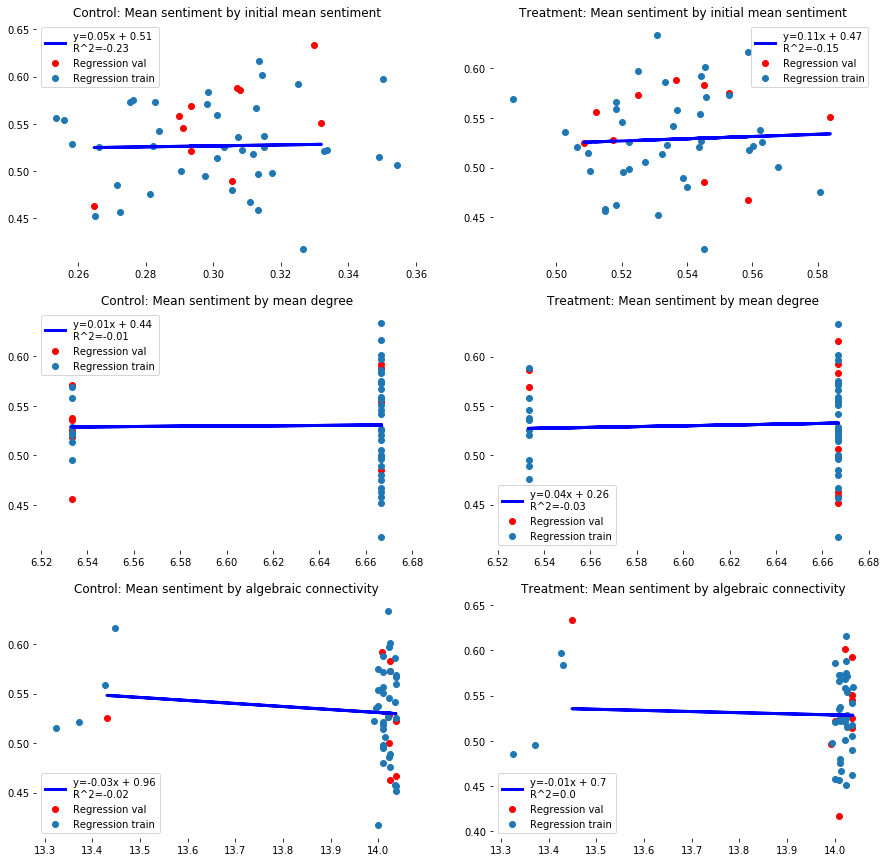

In [42]:
means = np.array([firm.get_mean_sentiment(15) for firm in F_contacted_set])

indicators = {
    'Control: Mean sentiment by initial mean sentiment': [firm.get_stats()['initial_mean'] for firm in F_control_set],
    'Treatment: Mean sentiment by initial mean sentiment': [firm.get_stats()['initial_mean'] for firm in F_contacted_set],
    'Control: Mean sentiment by mean degree': [firm.get_stats()['mean_degree'] for firm in F_control_set],
    'Treatment: Mean sentiment by mean degree': [firm.get_stats()['mean_degree'] for firm in F_contacted_set],
    'Control: Mean sentiment by algebraic connectivity': [firm.get_stats()['lapl_mat'][1] for firm in F_control_set],
    'Treatment: Mean sentiment by algebraic connectivity': [firm.get_stats()['lapl_mat'][1] for firm in F_contacted_set]
}

for i, (title, indicator) in enumerate(indicators.items()):
    plt.subplot(3, 2, i + 1)
    plt.title(title)
    regress(np.array(indicator), means)
